# Project Simulation & Optimization
Given is a rod with cross-section $A$, length $l$ and thermal conductivity $\lambda$, exposed to a constant heat supply $Q_0$ along the rod.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The temperature profile is described by the differential equation:  
$T'' + \dfrac{Q_0}{\lambda\,A}=0$  
The analytical solution would be obtained by integrating and using the boundary conditions $T(0)=0$ and $T(l)=0$:  
$T = -\dfrac{Q_0}{2\,\lambda\,A}\,x^2 + \dfrac{Q_0\,l}{2\,\lambda\,A}\,x$

### System Parameters

In [35]:
nodes = 500 # num of nodes for discretization, change to lower value if benchmark takes too long
Q0 = 15 # J/m^2s
lamb = 5 # J/°Cms
Across = 1e-4 # m^2
l = 1 # m

### Analytical Function of $T$

Text(0, 0.5, 'temperature on beam in °C')

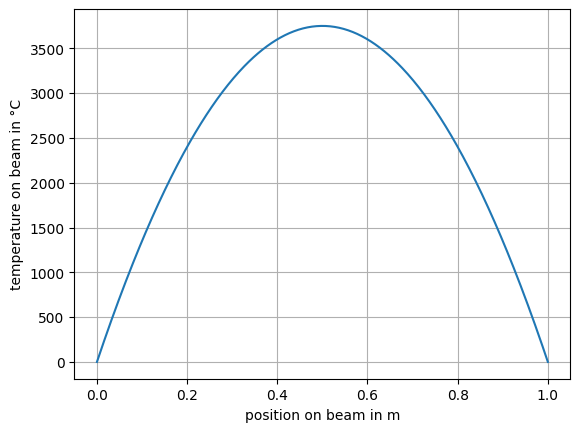

In [44]:
def T(x):
    return -Q0/(2*lamb*Across)*x**2 + Q0/(2*lamb*Across)*x

def T_dd(x):
    return np.ones_like(x)*-Q0/(2*lamb*Across)

x = np.linspace(0, 1, nodes)
T_analytic = T(x)
plt.plot(x, T_analytic)
plt.grid()
plt.xlabel("position on beam in m")
plt.ylabel("temperature on beam in °C")

### System of equations: finite difference method
To make matrix A symmetric, the first and last element are left out (boundary conditions) and added after solving the rest.

In [37]:
def gen_system_of_eq(n):
    h = 1/(n+1)

    A = (2*np.eye(n) - np.eye(n, k=1) - np.eye(n, k=-1))
    b = np.full(n, Q0 / (lamb * Across))*h**2

    return A, b

A, b = gen_system_of_eq(np.size(x)-2)

print(A)

# sparse matrix representation A ( (row,col) val )
import scipy.sparse as sp
spA = sp.csr_matrix(A)
print(spA)

[[ 2. -1.  0. ...  0.  0.  0.]
 [-1.  2. -1. ...  0.  0.  0.]
 [ 0. -1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ... -1.  2. -1.]
 [ 0.  0.  0. ...  0. -1.  2.]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1492 stored elements and shape (498, 498)>
  Coords	Values
  (0, 0)	2.0
  (0, 1)	-1.0
  (1, 0)	-1.0
  (1, 1)	2.0
  (1, 2)	-1.0
  (2, 1)	-1.0
  (2, 2)	2.0
  (2, 3)	-1.0
  (3, 2)	-1.0
  (3, 3)	2.0
  (3, 4)	-1.0
  (4, 3)	-1.0
  (4, 4)	2.0
  (4, 5)	-1.0
  (5, 4)	-1.0
  (5, 5)	2.0
  (5, 6)	-1.0
  (6, 5)	-1.0
  (6, 6)	2.0
  (6, 7)	-1.0
  (7, 6)	-1.0
  (7, 7)	2.0
  (7, 8)	-1.0
  (8, 7)	-1.0
  (8, 8)	2.0
  :	:
  (489, 489)	2.0
  (489, 490)	-1.0
  (490, 489)	-1.0
  (490, 490)	2.0
  (490, 491)	-1.0
  (491, 490)	-1.0
  (491, 491)	2.0
  (491, 492)	-1.0
  (492, 491)	-1.0
  (492, 492)	2.0
  (492, 493)	-1.0
  (493, 492)	-1.0
  (493, 493)	2.0
  (493, 494)	-1.0
  (494, 493)	-1.0
  (494, 494)	2.0
  (494, 495)	-1.0
  (495, 494)	-1.0
  (495, 495)	2.0
  (49

### Benchmark decorator

In [45]:
import time
import timeit

# time recorder decorator (inspired by Matthias Panny)
def timedit(func):
    def wrapper(*args, **kwargs):
        #start_time = time.time()
        result = func(*args, **kwargs)
        #end_time = time.time()
        #execution_time = end_time - start_time
        #print(f"Function '{func.__name__}' executed in: {execution_time:.4f} seconds")
        return result
    return wrapper

### Solver implementations

#### helper functions

In [39]:
def backward_sub(U, b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, n):
            s += U[i, j] * x[j]
        x[i] = (b[i] - s) / U[i, i]
    return x

def forward_sub(L, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        y[i] = (b[i] - s) / L[i, i]
    return y

def apply_init_conditions(T, T0, TE):
    T_new = np.zeros(np.size(T)+2)
    T_new[1:-1] = T
    T_new[0] = T0
    T_new[-1] = TE
    return T_new

def is_pos_def(A):
    return np.all(np.linalg.eigvals(A) > 0)

#### Direct solver implementations

In [ ]:
@timedit
def solve_numpy(A,b):
    return np.linalg.solve(A,b)

@timedit
def classic_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)

    # factorization
    for i in range(n - 1):
        for j in range(i + 1, n):
            lji = A[j, i] / A[i, i]

            for k in range(i, n):
                A[j, k] -= lji * A[i, k]

            b[j] -= lji * b[i]

    # back subs.
    x = backward_sub(A,b)
    return x

@timedit
def vector_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)
    V = np.hstack((A, b.reshape(-1,1))) # concatting A & b

    for i in range(n):
        piv = V[i,i] # pivot element

        ls = V[i+1:,i] / piv # vector with scaling fdactors
        V[i+1:,i:] -= V[i,i:] * ls.reshape(-1, 1) # entire matrix below and to right of pivot element at once
        
    x = backward_sub(V[:, :-1], V[:,-1]) # extract A and b from V
    return x
        
@timedit
def cholesky(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    C = np.zeros_like(A)
    n = len(b)

    # factorization and decomposition
    for i in range(n):
        c = 0.0
        for k in range(i):
            c += A[i, k] ** 2
        A[i, i] = np.sqrt(A[i, i] - c)

        # below diagonal
        for j in range(i + 1, n):
            c = 0.0
            for k in range(i):
                c += A[i, k] * A[j, k]
            A[j, i] = (A[j, i] - c) / A[i, i]

            C[j, i] = A[j, i]
    
    y = forward_sub(C,b)
    x = backward_sub(C.T, y)

    return x

def tridiagonal_cholesky(A, b):
    # [[d0 e0 ...        ]      [[b0]
    #  [e0 d1 e1 ...     ]       [b1]
    #  [ :  e1 d2 e2 ... ]       [: ]
    #  [ . ... ...   ... ]]      [: ]]

    A = A.copy().astype(float)
    b = b.copy().astype(float)
    C = np.zeros_like(A)
    n = len(b)

    d = A.diagonal(0).copy()
    e = A.diagonal(-1).copy()

    l = np.zeros(n)
    m = np.zeros(n-1)

    # factorization
    l[0] = np.sqrt(d[0])

    for i in range(1, n):
        m[i-1] = e[i-1] / l[i-1]
        l[i] = np.sqrt(d[i] - m[i-1]**2)

    # forward sub C*y = b
    y = np.zeros(n)
    y[0] = b[0] / l[0]

    for i in range(1, n):
        y[i] = (b[i] - m[i-1]*y[i-1]) / l[i]
    
    # back sub C^T*x = y
    x = np.zeros(n)
    x[-1] = y[-1] / l[-1]

    for i in range(n-2, -1, -1):
        x[i] = (y[i] - m[i]*x[i+1]) / l[i]

    return x

@timedit
def thomas_algorithm(A,d): # https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    # [[b0 c1 ...        ]      [[d0]
    #  [a1 b1 c2 ...     ]       [d1]
    #  [ :  a2 b2 c3 ... ]       [: ]
    #  [ . ... ...   ... ]]      [: ]]

    A = A.astype(float)
    d = d.astype(float)

    n = len(d)
    x = np.zeros(n)

    a = A.diagonal(-1).copy() # copy so that not read-only
    b = A.diagonal(0).copy()
    c = A.diagonal(1).copy()

    # sweep
    for i in range(1, n):
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    # back sub
    x[n-1] = d[n-1] / b[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]

    return x


#### iterative solver implementations

In [41]:
@timedit
def richardson_iteration(A, b, x0, theta, nmax):
    x = x0
    tol = 1e-8
    for i in range(nmax):
        r = A @ x - b

        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            return x
        x = x - theta*r
    
    print("Richardson did not converge!")
    return x

@timedit
def steepest_gradient(A, b, x0, nmax, returnInfo=False):
    n = len(b)
    x = x0
    tol = 1e-8

    r = A @ x - b
    if returnInfo == True: residual = []
    for i in range(nmax):
        alpha = r.T @ r / (r.T @ A @ r)
        x = x - alpha * r
        r = A @ x - b
        if returnInfo == True: residual.append(np.linalg.norm(r) / np.linalg.norm(b))
        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            if returnInfo == True:
                return x, residual
            else:
                return x
        
    print("Steepest Gradient did not converge!")
    if returnInfo == True:
        return x, residual
    else:
        return x

@timedit
def conjugate_gradient(A, b, x0, nmax, returnInfo=False):
    x = x0
    tol = 1e-8
    r = A @ x - b
    s = -r
    if returnInfo == True: residual = []
    for i in range(nmax):
        alpha = - (s.T @ r / (s.T @ A @ s))
        x = x + alpha*s
        r = A @ x - b

        if returnInfo == True: residual.append(np.linalg.norm(r) / np.linalg.norm(b))
        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            if returnInfo == True:
                return x, residual
            else:
                return x
        
        beta = r.T @ A @ s / (s.T @ A @ s)
        s = -r + beta*s
    
    print("Conjugate Gradient did not converge!")
    if returnInfo == True:
        return x, residual
    else:
        return x
    

#### Matrix A properties

In [42]:
if np.allclose(A, A.T):
    print("A is symmetric!")
else:
    print("A is not symmetric!")

if is_pos_def(A):
    print("A is positive definite!")
else:
    print("A is not positive definite!")

print(f"Condition number: {np.linalg.cond(A)}") # same as lambda_max/lambda_min

A is symmetric!
A is positive definite!
Condition number: 100915.63752574871


### Direct Solving
5 direct solver algorithms have been implemented. The standard **Gauss elimination**, a special **vectorized Gauss elimination**, which replaces two of the three necessary for-loops with quick numpy calculations, the standard **Cholesky decomposition**, a **Tridiagonal Cholesky decomposition** which only works for this specific type of matrix (tridiagonal), and the so-called **tridiagonal matrix -** or **[Thomas-algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm)**.

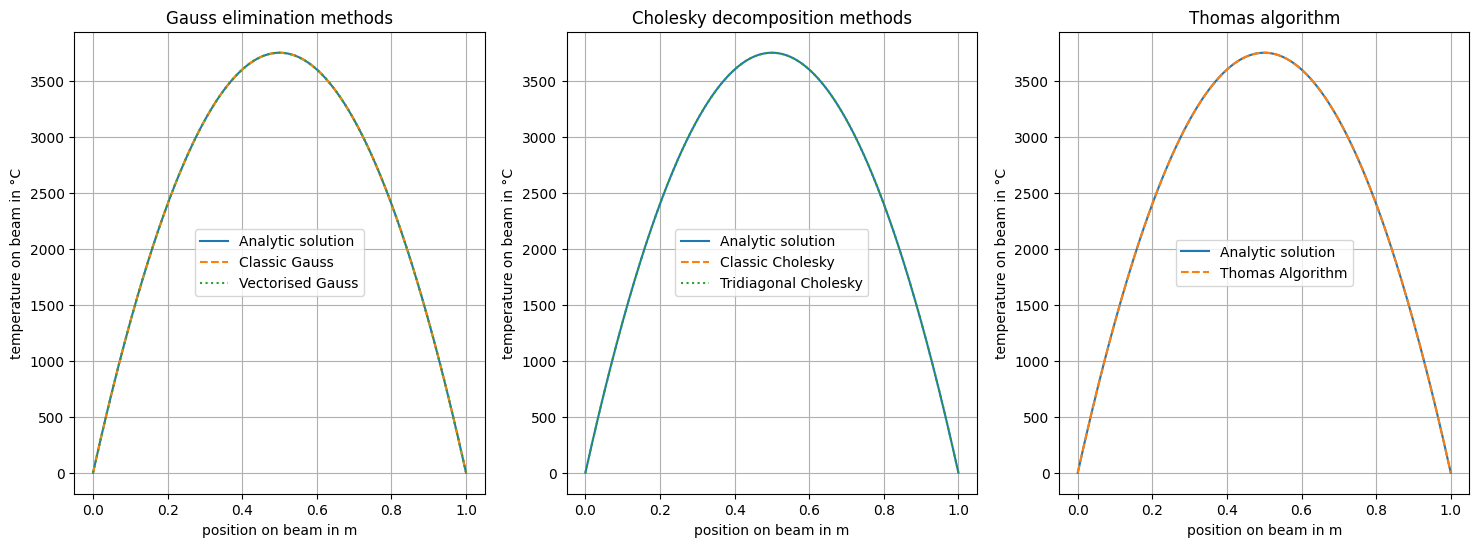

In [ ]:
T_gauss = classic_gauss(A, b)
T_gauss = apply_init_conditions(T_gauss, 0, 0)

T_vec_gauss = vector_gauss(A,b)
T_vec_gauss = apply_init_conditions(T_vec_gauss, 0, 0)

T_cholesky = cholesky(A, b)
T_cholesky = apply_init_conditions(T_cholesky, 0, 0)

T_cholesky_tridiag = tridiagonal_cholesky(A, b)
T_cholesky_tridiag = apply_init_conditions(T_cholesky_tridiag, 0, 0)

T_thomas = thomas_algorithm(A, b)
T_thomas = apply_init_conditions(T_thomas, 0, 0)

fig, ax = plt.subplots(1,3, figsize=(18,6))
for axis in ax:
    axis.plot(x, T_analytic, label="Analytic solution")
    axis.grid()
    axis.set_xlabel("position on beam in m")
    axis.set_ylabel("temperature on beam in °C")
ax[0].plot(x, T_gauss, label="Classic Gauss", linestyle="--")
ax[0].plot(x, T_vec_gauss, label="Vectorized Gauss", linestyle=":")
ax[0].set_title("Gauss elimination methods")
ax[1].plot(x, T_cholesky, label="Classic Cholesky", linestyle="--")
ax[1].set_title("Cholesky decomposition methods")
ax[1].plot(x, T_cholesky_tridiag, label="Tridiagonal Cholesky", linestyle=":")
ax[2].plot(x, T_thomas, label="Thomas Algorithm", linestyle="--")
ax[2].set_title("Thomas algorithm")
for axis in ax: axis.legend(loc="center")
plt.show()

As can be seen, all the implemented methods yield a similar solution to the analytic one. The only difference between them is the execution time and the amount of memory needed, which is discussed further below.

#### Iterative Solving
Three types of iterative solvers have been implemented, the **Richardson iteration**, the **Steepest gradient method** and the **Conjugate gradient method**. There was also the attempt to investigate if using **scipy.sparse.csr** instead of the full matrix $\utilde{A}$ would also work.

Richardson did not converge!
Steepest Gradient did not converge!


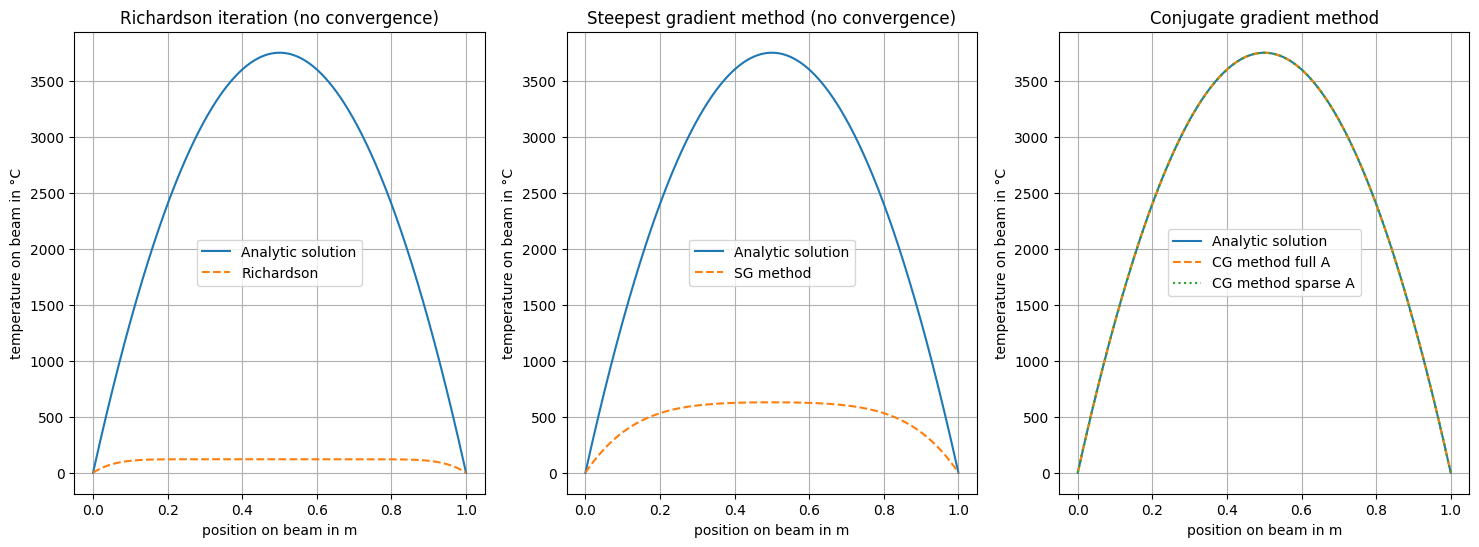

In [49]:
T_richard = richardson_iteration(A, b, np.zeros_like(b), 0.1, 10000)
T_richard = apply_init_conditions(T_richard, 0, 0)

T_steep_grad, residual_sg = steepest_gradient(A, b, np.zeros_like(b), 10000, returnInfo=True)
T_steep_grad = apply_init_conditions(T_steep_grad, 0, 0)

T_conj_grad, residual_cg = conjugate_gradient(A, b, np.zeros_like(b), 10000, returnInfo=True)
T_conj_grad = apply_init_conditions(T_conj_grad, 0, 0)

T_conj_sparse = conjugate_gradient(spA, b, np.zeros_like(b), 10000)
T_conj_sparse = apply_init_conditions(T_conj_sparse, 0, 0)

fig, ax = plt.subplots(1,3, figsize=(18,6))
for axis in ax:
    axis.plot(x, T_analytic, label="Analytic solution")
    axis.grid()
    axis.set_xlabel("position on beam in m")
    axis.set_ylabel("temperature on beam in °C")
ax[0].plot(x, T_richard, label="Richardson", linestyle="--")
ax[0].set_title("Richardson iteration (no convergence)")
ax[1].plot(x, T_steep_grad, label="SG method", linestyle="--")
ax[1].set_title("Steepest gradient method (no convergence)")
ax[2].plot(x, T_conj_grad, label="CG method full A", linestyle="--")
ax[2].plot(x, T_conj_sparse, label="CG method sparse A", linestyle=":")
ax[2].set_title("Conjugate gradient method")
for axis in ax: axis.legend(loc="center")
plt.show()

In these experiments, the richardson iteration and the steepest gradient method did not converge to the solution. As $\utilde{A}$ is a SPD-matrix, the steepest gradient should converge; the fact that it did not is probably because of too little steps or due to the problem being "slightly" ill-conditioned ($\kappa\approx 100000$ for $n=500$).

### Time performance over $n$
The purpose of the following plot is to visualize the behaviour of the algorithms over an increasing amount of $n$

In [68]:
ns = [5, 10, 20, 50, 100, 200, 500, 700]
t_cls_gauss, t_vec_gauss, t_cls_chol, t_trid_chol, t_numpy, t_thomas, t_cg, t_cg_sparse = [], [], [], [], [], [], [], []

for en in ns:
    An, bn = gen_system_of_eq(en)
    spAn = sp.csr_matrix(An)
    t_cls_gauss.append(timeit.timeit(stmt=lambda: classic_gauss(An,bn), number=1))
    t_vec_gauss.append(timeit.timeit(stmt=lambda: vector_gauss(An,bn), number=1))
    t_cls_chol.append(timeit.timeit(stmt=lambda: cholesky(An,bn), number=1))
    t_trid_chol.append(timeit.timeit(stmt=lambda: tridiagonal_cholesky(An,bn), number=1))
    t_numpy.append(timeit.timeit(stmt=lambda: solve_numpy(An,bn), number=1))
    t_thomas.append(timeit.timeit(stmt=lambda: thomas_algorithm(An,bn), number=1))
    t_cg.append(timeit.timeit(stmt=lambda: conjugate_gradient(An, bn, np.zeros_like(bn), 10000), number=1))
    t_cg_sparse.append(timeit.timeit(stmt=lambda: conjugate_gradient(spAn, bn, np.zeros_like(bn), 10000), number=1))

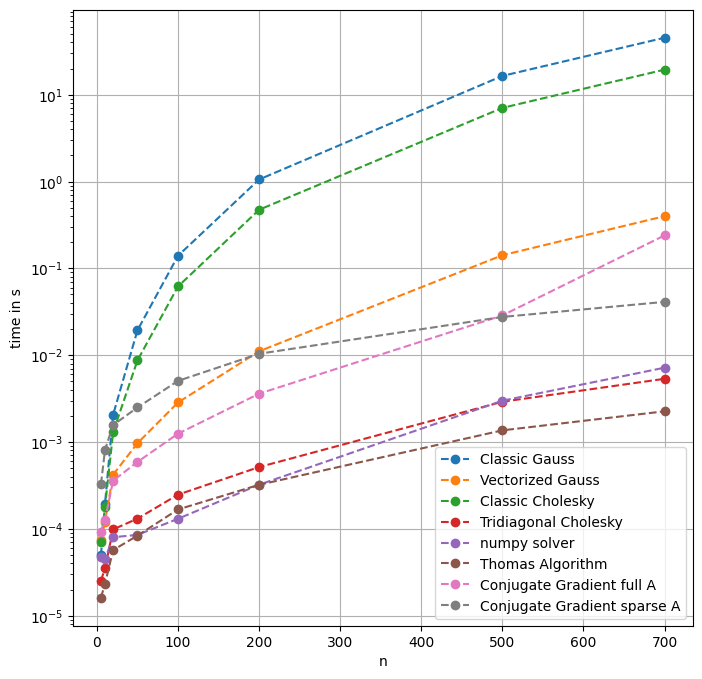

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.semilogy(ns, t_cls_gauss, label="Classic Gauss", linestyle="--", marker="o")
ax.semilogy(ns, t_vec_gauss, label="Vectorized Gauss", linestyle="--", marker="o")
ax.semilogy(ns, t_cls_chol, label="Classic Cholesky", linestyle="--", marker="o")
ax.semilogy(ns, t_trid_chol, label="Tridiagonal Cholesky", linestyle="--", marker="o")
ax.semilogy(ns, t_numpy, label="numpy solver", linestyle="--", marker="o")
ax.semilogy(ns, t_thomas, label="Thomas Algorithm", linestyle="--", marker="o")
ax.semilogy(ns, t_cg, label="Conjugate Gradient full A", linestyle="--", marker="o")
ax.semilogy(ns, t_cg_sparse, label="Conjugate Gradient sparse A", linestyle="--", marker="o")
ax.legend(loc="lower right")
ax.set_ylabel("time in s")
ax.set_xlabel("n")
ax.grid()

plt.show()

It is visible that the **classic Gauss elimination** and **Cholesky decomposition** take the longest time to execute. The special **Vectorized Gauss elimination** comes next, followed by the **Conjugate Gradient method**. It is notable, that doing the calculations for **CG** with a *scipy.sparse.csr_matrix* object takes a larger amount of time for smaller $n$, and becomes more efficient the larger $n$ becomes, compared to alway using the full matrix $\utilde{A}$.  
The fastest self-implemented algorithms are the **Cholesky Decomposition for Tridiagonal matrices** and the **Thomas-Algorithm**.

### Time performance ranking
Every algorithm has been run 5 times in succession with $n=500$, measuring the execution time and taking the average value. The results can be seen in the table below. The values obviously depend on the hardware. The code to evaluate these values can be seen [HERE](#solving-benchmark).

| Ranking | Method                         | Execution time               | Theoretical memory needed              |
|---------|--------------------------------|------------------------------|----------------------------------------|
| 1       | Thomas algorithm               | $\approx 0.0012\,\mathrm{s}$ | $\approx 3\,n$                         |
| 2       | Tridiagonal Cholesky decomp.   |                              | $\approx 3\,n$                         |
| 2       | numpy.linalg.solve             | $\approx 0.0038\,\mathrm{s}$ | unknown                                |
| 3       | Conjugate gradient w. sparse A | $\approx 0.017\,\mathrm{s}$  | $\approx 3\,n$                         |
| 4       | Conjugate gradient             | $\approx 0.036\,\mathrm{s}$  | $\approx n^3$                          |
| 5       | Vectorized Gauss elimination   | $\approx 0.14\,\mathrm{s}$   | $\approx n^3$                          |
| 6       | Cholesky decomp.               | $\approx 4.90\,\mathrm{s}$   | $\approx n^3$                          |
| 7       | Classic Gauss elimination      | $\approx 12.11\,\mathrm{s}$  | $\approx n^3$                          |
| 8       | Steepest gradient              | no convergence               | $n^3$ or $3\,n$ w. sparse $\utilde{A}$ |
| 9       | Richardson iteration           | no convergence               | $n^3$ or $3\,n$ w. sparse $\utilde{A}$ |

#### Solving benchmark
Uncomment the section below to run the benchmark. It could take some time.  
Reduce **nodes** parameter under **System Parameters** [HERE](#system-parameters) if it is taking too long. The **Richardson iteration** and the **Steepest gradient method** are excluded because they did not converge.

In [ ]:
cycles = 5

print("Performance direct solvers:")
print(f"Avg. execution time classic gauss: {timeit.timeit(stmt=lambda: classic_gauss(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time vectorized gauss: {timeit.timeit(stmt=lambda: vector_gauss(A,b), number=cycles)/cycles} seconds")

print(f"Avg. execution time cholesky: {timeit.timeit(stmt=lambda: cholesky(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time tridiagonal cholesky: {timeit.timeit(stmt=lambda: tridiagonal_cholesky(A,b), number=cycles)/cycles} seconds")

print(f"Avg. execution time numpy solve: {timeit.timeit(stmt=lambda: solve_numpy(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time thomas algorithm: {timeit.timeit(stmt=lambda: thomas_algorithm(A,b), number=cycles)/cycles} seconds")


print("\nPerformance iterative solvers:")
print(f"Avg. execution time conjugate gradient: {timeit.timeit(stmt=lambda: conjugate_gradient(A, b, np.zeros_like(b), 10000), number=cycles)/cycles} seconds")
print(f"Avg. execution time conjugate gradient sparse A: {timeit.timeit(stmt=lambda: conjugate_gradient(spA, b, np.zeros_like(b), 10000), number=cycles)/cycles} seconds")

Performance direct solvers:
Avg. execution time classic gauss: 16.344355059999906 seconds
Avg. execution time vectorized gauss: 0.126574840000103 seconds
Avg. execution time cholesky: 6.993460159999995 seconds
Avg. execution time triadiagonal cholesky: 0.0023580600001878336 seconds
Avg. execution time numpy solve: 0.002630480000152602 seconds
Avg. execution time thomas algorithm: 0.0011982599997281795 seconds

Performance iterative solvers:
Avg. execution time conjugate gradient: 0.028719900000214692 seconds
Avg. execution time conjugate gradient sparse A: 0.027294659999824944 seconds
